# 1. Setup and Imports
First, let's import all necessary libraries and set up the environment:

In [1]:
# Cell 1: Install required packages (if needed)
# Uncomment the following line if running in a fresh environment
# !pip install torch torchvision opencv-python scikit-learn matplotlib tqdm pillow

# Cell 2: Import libraries
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import json
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


In [2]:
# Cell 3: Configuration settings
# Update these paths according to your dataset location
DATASET_PATH = "/kaggle/input/indian-actor-images-dataset/Bollywood Actor Images/Bollywood Actor Images"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
TEST_SIZE = 0.2

print("Configuration:")
print(f"Dataset Path: {DATASET_PATH}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Epochs: {EPOCHS}")
print(f"Test Split: {TEST_SIZE}")

Configuration:
Dataset Path: /kaggle/input/indian-actor-images-dataset/Bollywood Actor Images/Bollywood Actor Images
Image Size: 224x224
Batch Size: 32
Training Epochs: 50
Test Split: 0.2


# 2. Dataset Class
Define the custom dataset class for loading Bollywood celebrity images:

In [3]:
# Cell 4: Custom Dataset Class
class BollywoodDataset(Dataset):
    """Custom dataset class for Bollywood celebrity images"""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✅ BollywoodDataset class defined")

✅ BollywoodDataset class defined


# 3. Model Architecture
Define the neural network architectures for face recognition and attribute prediction:

In [4]:
# Cell 5: Main Face Recognition Model
class BollywoodFaceNet(nn.Module):
    """Main face recognition network using ResNet50 backbone"""
    
    def __init__(self, num_classes, pretrained=True):
        super(BollywoodFaceNet, self).__init__()
        
        # Use ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Remove the final classification layer
        self.features = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Add custom classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
        # Feature extractor for similarity matching
        self.feature_extractor = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256)
        )
    
    def forward(self, x, return_features=False):
        # Extract features using backbone
        features = self.features(x)
        features = torch.flatten(features, 1)
        
        if return_features:
            # Return both classification and feature embeddings
            embeddings = self.feature_extractor(features)
            logits = self.classifier(features)
            return logits, embeddings
        else:
            # Return only classification logits
            logits = self.classifier(features)
            return logits

print("✅ BollywoodFaceNet model defined")

✅ BollywoodFaceNet model defined


In [5]:
# Cell 6: Attribute Prediction Model
class AttributeNet(nn.Module):
    """Network for predicting facial attributes like skin tone, complexion, texture"""
    
    def __init__(self):
        super(AttributeNet, self).__init__()
        
        # Use MobileNetV2 for efficiency
        self.backbone = models.mobilenet_v2(pretrained=True)
        self.backbone.classifier = nn.Identity()  # Remove final layer
        
        # Attribute prediction heads
        self.skin_tone_head = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 3)  # RGB values
        )
        
        self.complexion_head = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 3)  # Fair, Medium, Dark
        )
        
        self.texture_head = nn.Sequential(
            nn.Linear(1280, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # Smooth, Textured
        )
    
    def forward(self, x):
        features = self.backbone(x)
        
        skin_tone = self.skin_tone_head(features)
        complexion = self.complexion_head(features)
        texture = self.texture_head(features)
        
        return {
            'skin_tone': skin_tone,
            'complexion': complexion,
            'texture': texture
        }

print("✅ AttributeNet model defined")

✅ AttributeNet model defined


# 4. Training Class
Create the main training class that handles data loading, preprocessing, and training:

In [6]:
# Cell 7: Training Class - Initialization
class BollywoodTrainer:
    """Main training class for Bollywood celebrity face recognition"""
    
    def __init__(self, dataset_path, img_size=224, batch_size=32):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print(f"Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"GPU: {torch.cuda.get_device_name(0)}")
            print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        
        self.label_encoder = LabelEncoder()
        self.celebrity_names = []
        self.model = None
        self.attribute_model = None
        
        # Data transforms
        self.train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.val_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Initialize trainer
trainer = BollywoodTrainer(DATASET_PATH, IMG_SIZE, BATCH_SIZE)
print("✅ BollywoodTrainer initialized")

Using device: cuda
GPU: Tesla T4
CUDA Memory: 15.8 GB
✅ BollywoodTrainer initialized


In [7]:
# Cell 8: Data Loading Methods
def load_dataset(trainer):
    """Load and preprocess the Bollywood celebrity dataset"""
    print("Loading dataset...")
    images = []
    labels = []
    
    # Check if dataset path exists
    if not os.path.exists(trainer.dataset_path):
        print(f"Dataset path not found: {trainer.dataset_path}")
        print("Available paths:")
        try:
            base_path = "/kaggle/input/indian-actor-images-dataset"
            for root, dirs, files in os.walk(base_path):
                level = root.replace(base_path, '').count(os.sep)
                indent = ' ' * 2 * level
                print(f"{indent}{os.path.basename(root)}/")
                subindent = ' ' * 2 * (level + 1)
                for file in files[:5]:  # Show first 5 files
                    print(f"{subindent}{file}")
                if len(files) > 5:
                    print(f"{subindent}... and {len(files)-5} more files")
        except:
            pass
        raise FileNotFoundError(f"Dataset path not found: {trainer.dataset_path}")
    
    # Get all celebrity folders
    celebrity_folders = []
    for item in os.listdir(trainer.dataset_path):
        item_path = os.path.join(trainer.dataset_path, item)
        if os.path.isdir(item_path):
            # Check if folder contains images
            image_files = [f for f in os.listdir(item_path) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            if image_files:
                celebrity_folders.append(item)
    
    if not celebrity_folders:
        raise ValueError(f"No celebrity folders with images found in {trainer.dataset_path}")
    
    trainer.celebrity_names = sorted(celebrity_folders)
    print(f"Found {len(trainer.celebrity_names)} celebrities: {trainer.celebrity_names[:5]}{'...' if len(trainer.celebrity_names) > 5 else ''}")
    
    # Count total images first
    total_images = 0
    for celebrity in trainer.celebrity_names:
        celebrity_path = os.path.join(trainer.dataset_path, celebrity)
        celebrity_images = [f for f in os.listdir(celebrity_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        total_images += len(celebrity_images)
    
    print(f"Total images to load: {total_images}")
    
    # Load images with progress bar
    loaded_count = 0
    failed_count = 0
    
    for celebrity in tqdm(trainer.celebrity_names, desc="Loading celebrities"):
        celebrity_path = os.path.join(trainer.dataset_path, celebrity)
        celebrity_images = [f for f in os.listdir(celebrity_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        for img_file in celebrity_images:
            img_path = os.path.join(celebrity_path, img_file)
            try:
                # Load image using PIL
                img = Image.open(img_path).convert('RGB')
                # Basic validation - check if image is not corrupted
                img.verify()
                # Reload image after verify (verify closes the file)
                img = Image.open(img_path).convert('RGB')
                
                images.append(img)
                labels.append(celebrity)
                loaded_count += 1
            except Exception as e:
                failed_count += 1
                if failed_count <= 10:  # Only print first 10 errors
                    print(f"Error loading {img_path}: {e}")
                continue
    
    if not images:
        raise ValueError("No images could be loaded from the dataset")
    
    # Encode labels
    labels_encoded = trainer.label_encoder.fit_transform(labels)
    
    print(f"Dataset loaded successfully:")
    print(f"  - {loaded_count} images loaded")
    print(f"  - {failed_count} images failed to load")
    print(f"  - {len(trainer.celebrity_names)} celebrities")
    print(f"  - Average images per celebrity: {loaded_count/len(trainer.celebrity_names):.1f}")
    
    return images, labels_encoded

# Load the dataset
images, labels = load_dataset(trainer)

Loading dataset...
Found 135 celebrities: ['abhay_deol', 'adil_hussain', 'ajay_devgn', 'akshay_kumar', 'akshaye_khanna']...
Total images to load: 6750


Loading celebrities: 100%|██████████| 135/135 [01:05<00:00,  2.07it/s]

Dataset loaded successfully:
  - 6750 images loaded
  - 0 images failed to load
  - 135 celebrities
  - Average images per celebrity: 50.0


In [8]:
# Cell 9: Create Data Loaders
def create_data_loaders(trainer, images, labels, test_size=0.2):
    """Create train and validation data loaders"""
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, test_size=test_size, random_state=42, stratify=labels
    )
    
    # Create datasets
    train_dataset = BollywoodDataset(X_train, y_train, trainer.train_transform)
    val_dataset = BollywoodDataset(X_val, y_val, trainer.val_transform)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=trainer.batch_size, shuffle=True, 
        num_workers=4, pin_memory=True if torch.cuda.is_available() else False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=trainer.batch_size, shuffle=False,
        num_workers=4, pin_memory=True if torch.cuda.is_available() else False
    )
    
    return train_loader, val_loader

# Create data loaders
train_loader, val_loader = create_data_loaders(trainer, images, labels, TEST_SIZE)
print(f"✅ Data loaders created")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

✅ Data loaders created
Train samples: 5400
Validation samples: 1350


In [9]:
# Cell 10: Attribute Extraction Methods
def extract_face_attributes_batch(images):
    """Extract facial attributes for batch of images"""
    attributes = {
        'skin_tone': [],
        'complexion': [],
        'texture': []
    }
    
    for img_tensor in images:
        # Convert tensor back to numpy for analysis
        img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
        # Denormalize
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        # Extract attributes
        h, w = img_np.shape[:2]
        face_region = img_np[int(h*0.2):int(h*0.8), int(w*0.2):int(w*0.8)]
        
        # Skin tone (RGB averages)
        avg_rgb = np.mean(face_region.reshape(-1, 3), axis=0)
        attributes['skin_tone'].append(avg_rgb)
        
        # Complexion classification
        brightness = np.mean(avg_rgb)
        if brightness > 0.7:
            complexion = 0  # Fair
        elif brightness > 0.5:
            complexion = 1  # Medium
        else:
            complexion = 2  # Dark
        attributes['complexion'].append(complexion)
        
        # Texture (using standard deviation)
        gray = cv2.cvtColor((face_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        texture = 0 if np.std(gray) < 20 else 1  # Smooth vs Textured
        attributes['texture'].append(texture)
    
    return {
        'skin_tone': torch.tensor(attributes['skin_tone'], dtype=torch.float32),
        'complexion': torch.tensor(attributes['complexion'], dtype=torch.long),
        'texture': torch.tensor(attributes['texture'], dtype=torch.long)
    }

print("✅ Attribute extraction function defined")

✅ Attribute extraction function defined


# 5. Model Training
Train both the face recognition model and the attribute prediction model:

In [10]:
# Cell 11: Face Recognition Model Training
def train_face_recognition_model(trainer, train_loader, val_loader, num_epochs=50):
    """Train the main face recognition model"""
    print("Training face recognition model...")
    
    # Initialize model
    num_classes = len(trainer.celebrity_names)
    trainer.model = BollywoodFaceNet(num_classes).to(trainer.device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(trainer.model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    best_val_acc = 0.0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        trainer.model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(trainer.device), labels.to(trainer.device)
            
            optimizer.zero_grad()
            outputs = trainer.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        trainer.model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(trainer.device), labels.to(trainer.device)
                outputs = trainer.model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': trainer.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'celebrity_names': trainer.celebrity_names,
                'label_encoder': trainer.label_encoder
            }, 'best_bollywood_model.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
        
        scheduler.step(avg_train_loss)
        
        # Early stopping
        if optimizer.param_groups[0]['lr'] < 1e-7:
            print("Learning rate too small, stopping training")
            break
    
    return train_losses, val_accuracies

# Start training the face recognition model
train_losses, val_accuracies = train_face_recognition_model(trainer, train_loader, val_loader, EPOCHS)

Training face recognition model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]
Epoch 1/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  9.17it/s]


Epoch [1/50] - Loss: 4.9192, Val Acc: 0.89%
New best model saved with validation accuracy: 0.89%


Epoch 2/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.62it/s]


Epoch [2/50] - Loss: 4.9082, Val Acc: 0.67%


Epoch 3/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.97it/s]


Epoch [3/50] - Loss: 4.9087, Val Acc: 0.67%


Epoch 4/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.83it/s]


Epoch [4/50] - Loss: 4.9091, Val Acc: 0.81%


Epoch 5/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.89it/s]


Epoch [5/50] - Loss: 4.9076, Val Acc: 0.81%


Epoch 6/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.84it/s]


Epoch [6/50] - Loss: 4.9070, Val Acc: 0.96%
New best model saved with validation accuracy: 0.96%


Epoch 7/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.80it/s]


Epoch [7/50] - Loss: 4.9057, Val Acc: 0.81%


Epoch 8/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.80it/s]


Epoch [8/50] - Loss: 4.9015, Val Acc: 0.89%


Epoch 9/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.85it/s]


Epoch [9/50] - Loss: 4.8993, Val Acc: 0.74%


Epoch 10/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.85it/s]


Epoch [10/50] - Loss: 4.8960, Val Acc: 0.74%


Epoch 11/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch [11/50] - Loss: 4.8966, Val Acc: 0.89%


Epoch 12/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch [12/50] - Loss: 4.8971, Val Acc: 1.11%
New best model saved with validation accuracy: 1.11%


Epoch 13/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.65it/s]


Epoch [13/50] - Loss: 4.8954, Val Acc: 0.59%


Epoch 14/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.81it/s]


Epoch [14/50] - Loss: 4.8915, Val Acc: 0.74%


Epoch 15/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.84it/s]


Epoch [15/50] - Loss: 4.8831, Val Acc: 0.59%


Epoch 16/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.81it/s]


Epoch [16/50] - Loss: 4.8807, Val Acc: 0.59%


Epoch 17/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.87it/s]


Epoch [17/50] - Loss: 4.8772, Val Acc: 0.81%


Epoch 18/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.85it/s]


Epoch [18/50] - Loss: 4.8758, Val Acc: 0.59%


Epoch 19/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.89it/s]


Epoch [19/50] - Loss: 4.8776, Val Acc: 0.59%


Epoch 20/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.86it/s]


Epoch [20/50] - Loss: 4.8727, Val Acc: 0.89%


Epoch 21/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.78it/s]


Epoch [21/50] - Loss: 4.8721, Val Acc: 0.59%


Epoch 22/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch [22/50] - Loss: 4.8688, Val Acc: 0.89%


Epoch 23/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.84it/s]


Epoch [23/50] - Loss: 4.8666, Val Acc: 1.04%


Epoch 24/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.79it/s]


Epoch [24/50] - Loss: 4.8634, Val Acc: 0.81%


Epoch 25/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.75it/s]


Epoch [25/50] - Loss: 4.8598, Val Acc: 1.04%


Epoch 26/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch [26/50] - Loss: 4.8593, Val Acc: 1.33%
New best model saved with validation accuracy: 1.33%


Epoch 27/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.85it/s]


Epoch [27/50] - Loss: 4.8562, Val Acc: 1.78%
New best model saved with validation accuracy: 1.78%


Epoch 28/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.80it/s]


Epoch [28/50] - Loss: 4.8567, Val Acc: 0.81%


Epoch 29/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch [29/50] - Loss: 4.8496, Val Acc: 1.26%


Epoch 30/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.87it/s]


Epoch [30/50] - Loss: 4.8491, Val Acc: 1.26%


Epoch 31/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.83it/s]


Epoch [31/50] - Loss: 4.8571, Val Acc: 0.67%


Epoch 32/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.82it/s]


Epoch [32/50] - Loss: 4.8483, Val Acc: 1.11%


Epoch 33/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.86it/s]


Epoch [33/50] - Loss: 4.8459, Val Acc: 1.41%


Epoch 34/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.84it/s]


Epoch [34/50] - Loss: 4.8426, Val Acc: 1.41%


Epoch 35/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.76it/s]


Epoch [35/50] - Loss: 4.8408, Val Acc: 1.63%


Epoch 36/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.75it/s]


Epoch [36/50] - Loss: 4.8337, Val Acc: 1.56%


Epoch 37/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.74it/s]


Epoch [37/50] - Loss: 4.8420, Val Acc: 1.26%


Epoch 38/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.77it/s]


Epoch [38/50] - Loss: 4.8304, Val Acc: 1.26%


Epoch 39/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.64it/s]


Epoch [39/50] - Loss: 4.8283, Val Acc: 1.63%


Epoch 40/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.74it/s]


Epoch [40/50] - Loss: 4.8259, Val Acc: 1.26%


Epoch 41/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.86it/s]


Epoch [41/50] - Loss: 4.8200, Val Acc: 1.93%
New best model saved with validation accuracy: 1.93%


Epoch 42/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.80it/s]


Epoch [42/50] - Loss: 4.8140, Val Acc: 1.85%


Epoch 43/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.79it/s]


Epoch [43/50] - Loss: 4.8167, Val Acc: 1.56%


Epoch 44/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.90it/s]


Epoch [44/50] - Loss: 4.8031, Val Acc: 1.78%


Epoch 45/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.85it/s]


Epoch [45/50] - Loss: 4.7959, Val Acc: 1.63%


Epoch 46/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.78it/s]


Epoch [46/50] - Loss: 4.7875, Val Acc: 2.22%
New best model saved with validation accuracy: 2.22%


Epoch 47/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.81it/s]


Epoch [47/50] - Loss: 4.7682, Val Acc: 1.93%


Epoch 48/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.76it/s]


Epoch [48/50] - Loss: 4.7600, Val Acc: 1.56%


Epoch 49/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.88it/s]


Epoch [49/50] - Loss: 4.7616, Val Acc: 1.78%


Epoch 50/50 [Val]: 100%|██████████| 43/43 [00:04<00:00,  8.88it/s]

Epoch [50/50] - Loss: 4.7380, Val Acc: 1.85%


In [11]:
# Cell 12: Attribute Model Training
def train_attribute_model(trainer, train_loader, val_loader, num_epochs=30):
    """Train the facial attribute prediction model"""
    print("Training attribute prediction model...")
    
    trainer.attribute_model = AttributeNet().to(trainer.device)
    
    # Multi-task loss weights
    criterion_mse = nn.MSELoss()
    criterion_ce = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(trainer.attribute_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    for epoch in range(num_epochs):
        trainer.attribute_model.train()
        running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f'Attribute Epoch {epoch+1}/{num_epochs}')
        for images, _ in pbar:
            images = images.to(trainer.device)
            
            # Extract ground truth attributes
            gt_attributes = extract_face_attributes_batch(images)
            for key in gt_attributes:
                gt_attributes[key] = gt_attributes[key].to(trainer.device)
            
            optimizer.zero_grad()
            outputs = trainer.attribute_model(images)
            
            # Calculate multi-task loss
            skin_loss = criterion_mse(outputs['skin_tone'], gt_attributes['skin_tone'])
            complexion_loss = criterion_ce(outputs['complexion'], gt_attributes['complexion'])
            texture_loss = criterion_ce(outputs['texture'], gt_attributes['texture'])
            
            total_loss = skin_loss + complexion_loss + texture_loss
            total_loss.backward()
            optimizer.step()
            
            running_loss += total_loss.item()
            pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})
        
        scheduler.step()
        print(f'Attribute Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f}')
    
    # Save attribute model
    torch.save({
        'model_state_dict': trainer.attribute_model.state_dict(),
        'model_type': 'attribute_net'
    }, 'bollywood_attribute_model.pth')
    
    print("Attribute model saved!")

# Train the attribute model
train_attribute_model(trainer, train_loader, val_loader, num_epochs=30)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Training attribute prediction model...


100%|██████████| 13.6M/13.6M [00:00<00:00, 161MB/s]
Attribute Epoch 1/30: 100%|██████████| 169/169 [00:38<00:00,  4.44it/s, Loss=0.1698]


Attribute Epoch [1/30] - Loss: 0.4011


Attribute Epoch 2/30: 100%|██████████| 169/169 [00:37<00:00,  4.54it/s, Loss=0.1571]


Attribute Epoch [2/30] - Loss: 0.2998


Attribute Epoch 3/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.1513]


Attribute Epoch [3/30] - Loss: 0.2683


Attribute Epoch 4/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.2120]


Attribute Epoch [4/30] - Loss: 0.2557


Attribute Epoch 5/30: 100%|██████████| 169/169 [00:37<00:00,  4.52it/s, Loss=0.1950]


Attribute Epoch [5/30] - Loss: 0.2433


Attribute Epoch 6/30: 100%|██████████| 169/169 [00:37<00:00,  4.49it/s, Loss=0.2236]


Attribute Epoch [6/30] - Loss: 0.2223


Attribute Epoch 7/30: 100%|██████████| 169/169 [00:37<00:00,  4.46it/s, Loss=0.2077]


Attribute Epoch [7/30] - Loss: 0.2440


Attribute Epoch 8/30: 100%|██████████| 169/169 [00:37<00:00,  4.51it/s, Loss=0.1774]


Attribute Epoch [8/30] - Loss: 0.2068


Attribute Epoch 9/30: 100%|██████████| 169/169 [00:37<00:00,  4.54it/s, Loss=0.0568]


Attribute Epoch [9/30] - Loss: 0.2054


Attribute Epoch 10/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.1252]


Attribute Epoch [10/30] - Loss: 0.2206


Attribute Epoch 11/30: 100%|██████████| 169/169 [00:37<00:00,  4.50it/s, Loss=0.1137]


Attribute Epoch [11/30] - Loss: 0.2043


Attribute Epoch 12/30: 100%|██████████| 169/169 [00:37<00:00,  4.51it/s, Loss=0.2299]


Attribute Epoch [12/30] - Loss: 0.1861


Attribute Epoch 13/30: 100%|██████████| 169/169 [00:37<00:00,  4.45it/s, Loss=0.1162]


Attribute Epoch [13/30] - Loss: 0.1956


Attribute Epoch 14/30: 100%|██████████| 169/169 [00:37<00:00,  4.54it/s, Loss=0.2617]


Attribute Epoch [14/30] - Loss: 0.1904


Attribute Epoch 15/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.1178]


Attribute Epoch [15/30] - Loss: 0.1895


Attribute Epoch 16/30: 100%|██████████| 169/169 [00:37<00:00,  4.51it/s, Loss=0.4020]


Attribute Epoch [16/30] - Loss: 0.2084


Attribute Epoch 17/30: 100%|██████████| 169/169 [00:37<00:00,  4.48it/s, Loss=0.4698]


Attribute Epoch [17/30] - Loss: 0.2025


Attribute Epoch 18/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.1959]


Attribute Epoch [18/30] - Loss: 0.2201


Attribute Epoch 19/30: 100%|██████████| 169/169 [00:37<00:00,  4.47it/s, Loss=0.2829]


Attribute Epoch [19/30] - Loss: 0.2041


Attribute Epoch 20/30: 100%|██████████| 169/169 [00:37<00:00,  4.50it/s, Loss=0.1651]


Attribute Epoch [20/30] - Loss: 0.1970


Attribute Epoch 21/30: 100%|██████████| 169/169 [00:37<00:00,  4.52it/s, Loss=0.0938]


Attribute Epoch [21/30] - Loss: 0.1835


Attribute Epoch 22/30: 100%|██████████| 169/169 [00:37<00:00,  4.54it/s, Loss=0.5868]


Attribute Epoch [22/30] - Loss: 0.1799


Attribute Epoch 23/30: 100%|██████████| 169/169 [00:37<00:00,  4.46it/s, Loss=0.2700]


Attribute Epoch [23/30] - Loss: 0.1802


Attribute Epoch 24/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.1549]


Attribute Epoch [24/30] - Loss: 0.1855


Attribute Epoch 25/30: 100%|██████████| 169/169 [00:37<00:00,  4.46it/s, Loss=0.1912]


Attribute Epoch [25/30] - Loss: 0.1767


Attribute Epoch 26/30: 100%|██████████| 169/169 [00:37<00:00,  4.51it/s, Loss=0.2268]


Attribute Epoch [26/30] - Loss: 0.1749


Attribute Epoch 27/30: 100%|██████████| 169/169 [00:37<00:00,  4.50it/s, Loss=0.1704]


Attribute Epoch [27/30] - Loss: 0.1877


Attribute Epoch 28/30: 100%|██████████| 169/169 [00:37<00:00,  4.52it/s, Loss=0.1112]


Attribute Epoch [28/30] - Loss: 0.1883


Attribute Epoch 29/30: 100%|██████████| 169/169 [00:37<00:00,  4.49it/s, Loss=0.1533]


Attribute Epoch [29/30] - Loss: 0.1724


Attribute Epoch 30/30: 100%|██████████| 169/169 [00:37<00:00,  4.53it/s, Loss=0.0790]

Attribute Epoch [30/30] - Loss: 0.1550
Attribute model saved!


In [12]:
# Cell 13: Extract Celebrity Embeddings
def extract_celebrity_embeddings(trainer, train_loader):
    """Extract and save celebrity feature embeddings for matching"""
    print("Extracting celebrity embeddings...")
    
    trainer.model.eval()
    celebrity_embeddings = {name: [] for name in trainer.celebrity_names}
    
    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc="Extracting embeddings"):
            images = images.to(trainer.device)
            _, embeddings = trainer.model(images, return_features=True)
            
            for embedding, label in zip(embeddings, labels):
                celebrity_name = trainer.label_encoder.inverse_transform([label.item()])[0]
                celebrity_embeddings[celebrity_name].append(embedding.cpu().numpy())
    
    # Average embeddings for each celebrity
    avg_embeddings = {}
    for celebrity, embeddings in celebrity_embeddings.items():
        if embeddings:
            avg_embeddings[celebrity] = np.mean(embeddings, axis=0)
    
    # Save embeddings
    with open('celebrity_embeddings.pkl', 'wb') as f:
        pickle.dump(avg_embeddings, f)
    
    print("Celebrity embeddings saved!")
    return avg_embeddings

# Extract celebrity embeddings
celebrity_embeddings = extract_celebrity_embeddings(trainer, train_loader)

Extracting celebrity embeddings...


Extracting embeddings: 100%|██████████| 169/169 [00:23<00:00,  7.32it/s]

Celebrity embeddings saved!


In [13]:
# Cell 14: Save Metadata
def save_metadata(trainer):
    """Save training metadata"""
    metadata = {
        'celebrity_names': trainer.celebrity_names,
        'num_classes': len(trainer.celebrity_names),
        'img_size': trainer.img_size,
        'device_used': str(trainer.device)
    }
    
    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Save label encoder separately
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(trainer.label_encoder, f)
    
    print("Metadata saved!")

# Save all metadata
save_metadata(trainer)

Metadata saved!


# 6. Results and Visualization
Visualize the training results and display summary information:

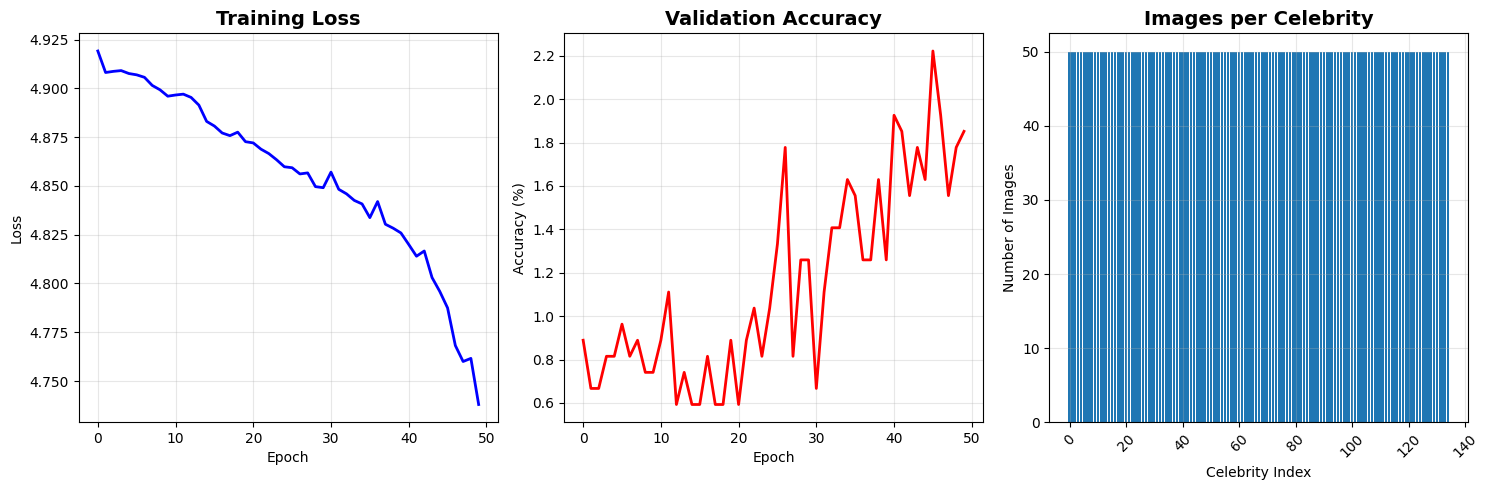

✅ Training visualization saved as 'training_results.png'


In [14]:
# Cell 15: Plot Training Curves
plt.figure(figsize=(15, 5))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, 'r-', linewidth=2)
plt.title('Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)

# Celebrity Distribution
plt.subplot(1, 3, 3)
celebrity_counts = [len([l for l in labels if trainer.label_encoder.inverse_transform([l])[0] == name]) 
                   for name in trainer.celebrity_names]
plt.bar(range(len(trainer.celebrity_names)), celebrity_counts)
plt.title('Images per Celebrity', fontsize=14, fontweight='bold')
plt.xlabel('Celebrity Index')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training visualization saved as 'training_results.png'")

In [15]:
# Cell 16: Training Summary
print("\n" + "="*60)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)

print(f"\n📊 Training Statistics:")
print(f"  • Total Celebrities: {len(trainer.celebrity_names)}")
print(f"  • Total Images: {len(images)}")
print(f"  • Training Images: {len(train_loader.dataset)}")
print(f"  • Validation Images: {len(val_loader.dataset)}")
print(f"  • Final Training Loss: {train_losses[-1]:.4f}")
print(f"  • Best Validation Accuracy: {max(val_accuracies):.2f}%")

print(f"\n💾 Saved Files:")
files_saved = [
    "best_bollywood_model.pth - Main face recognition model",
    "bollywood_attribute_model.pth - Facial attribute prediction model", 
    "celebrity_embeddings.pkl - Celebrity feature embeddings",
    "label_encoder.pkl - Label encoder for celebrity names",
    "model_metadata.json - Training metadata and configuration",
    "training_results.png - Training curves and statistics"
]

for file_info in files_saved:
    print(f"  ✓ {file_info}")

print(f"\n🌟 Top 10 Celebrities in Dataset:")
for i, name in enumerate(trainer.celebrity_names[:10]):
    count = len([l for l in labels if trainer.label_encoder.inverse_transform([l])[0] == name])
    print(f"  {i+1:2d}. {name} ({count} images)")

if len(trainer.celebrity_names) > 10:
    print(f"  ... and {len(trainer.celebrity_names) - 10} more celebrities")

print(f"\n🚀 Ready for inference! You can now use these models to:")
print("  • Recognize Bollywood celebrities from face images")
print("  • Extract facial features and attributes")
print("  • Perform similarity matching between faces")
print("="*60)


🎉 TRAINING COMPLETED SUCCESSFULLY!

📊 Training Statistics:
  • Total Celebrities: 135
  • Total Images: 6750
  • Training Images: 5400
  • Validation Images: 1350
  • Final Training Loss: 4.7380
  • Best Validation Accuracy: 2.22%

💾 Saved Files:
  ✓ best_bollywood_model.pth - Main face recognition model
  ✓ bollywood_attribute_model.pth - Facial attribute prediction model
  ✓ celebrity_embeddings.pkl - Celebrity feature embeddings
  ✓ label_encoder.pkl - Label encoder for celebrity names
  ✓ model_metadata.json - Training metadata and configuration
  ✓ training_results.png - Training curves and statistics

🌟 Top 10 Celebrities in Dataset:
   1. abhay_deol (50 images)
   2. adil_hussain (50 images)
   3. ajay_devgn (50 images)
   4. akshay_kumar (50 images)
   5. akshaye_khanna (50 images)
   6. amitabh_bachchan (50 images)
   7. amjad_khan (50 images)
   8. amol_palekar (50 images)
   9. amole_gupte (50 images)
  10. amrish_puri (50 images)
  ... and 125 more celebrities

🚀 Ready for

In [16]:
import shutil

# Define the name of the zip file
zip_filename = '/kaggle/working/output.zip'

# Create the zip archive of the entire /kaggle/working directory
shutil.make_archive(base_name=zip_filename.replace('.zip', ''), format='zip', root_dir='/kaggle/working')

print(f"All files zipped into {zip_filename}")


All files zipped into /kaggle/working/output.zip
